Part 1: Dataset Loader and Synthesizer
This part will load the audio files, apply preprocessing, and make the data ready for the model.

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import librosa

# Constants
SAMPLE_RATE = 16000
N_FFT = 512
HOP_LENGTH = 128

# Load and preprocess audio
def load_audio(file_path, sr=SAMPLE_RATE):
    y, _ = librosa.load(file_path, sr=sr)
    return y

def compute_stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH):
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    magnitude = np.abs(stft)
    phase = np.angle(stft)
    return magnitude, phase

def compute_phase_gradients(phase):
    delta_f = np.diff(phase, axis=0, prepend=0)  # Frequency gradient
    delta_t = np.diff(phase, axis=1, prepend=0)  # Temporal gradient
    return delta_f, delta_t

# Padding function to standardize input shape
def pad_or_truncate(tensor, target_shape):
    padded = torch.zeros(target_shape, dtype=tensor.dtype)
    min_shape = tuple(min(s, t) for s, t in zip(tensor.shape, target_shape))
    padded[:min_shape[0], :min_shape[1], :min_shape[2]] = tensor[:min_shape[0], :min_shape[1], :min_shape[2]]
    return padded

class SpeechEnhancementDataset(Dataset):
    def __init__(self, root_dir, dataset_type="training", target_shape=(1, 256, 255)):
        # Define paths for clean and noisy audio based on dataset type (training or testing)
        self.clean_dir = os.path.join(root_dir, dataset_type, 'CleanSpeech')
        self.noisy_dir = os.path.join(root_dir, dataset_type, 'NoisySpeech')
        
        # List all files in the clean and noisy directories
        self.clean_files = sorted([os.path.join(self.clean_dir, f) for f in os.listdir(self.clean_dir) if f.endswith('.wav')])
        self.noisy_files = sorted([os.path.join(self.noisy_dir, f) for f in os.listdir(self.noisy_dir) if f.endswith('.wav')])
        self.target_shape = target_shape

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        # Load clean and noisy audio files
        clean_audio = load_audio(self.clean_files[idx])
        noisy_audio = load_audio(self.noisy_files[idx])

        # Compute STFT magnitudes and phases
        clean_mag, clean_phase = compute_stft(clean_audio)
        noisy_mag, _ = compute_stft(noisy_audio)

        # Compute phase gradients for the clean audio
        delta_f, delta_t = compute_phase_gradients(clean_phase)

        # Convert to tensors and pad/truncate to target shape
        clean_mag = pad_or_truncate(torch.tensor(clean_mag, dtype=torch.float32).unsqueeze(0), self.target_shape)
        noisy_mag = pad_or_truncate(torch.tensor(noisy_mag, dtype=torch.float32).unsqueeze(0), self.target_shape)
        delta_f = pad_or_truncate(torch.tensor(delta_f, dtype=torch.float32).unsqueeze(0), self.target_shape)
        delta_t = pad_or_truncate(torch.tensor(delta_t, dtype=torch.float32).unsqueeze(0), self.target_shape)

        return noisy_mag, clean_mag, delta_f, delta_t

# Example usage
if __name__ == "__main__":
    # Initialize dataset and dataloader
    train_dataset = SpeechEnhancementDataset(root_dir='data', dataset_type='training')
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    
    # Testing the loader
    for noisy_mag, clean_mag, delta_f, delta_t in train_loader:
        print(f"Noisy Mag Shape: {noisy_mag.shape}, Clean Mag Shape: {clean_mag.shape}")
        print(f"Delta F Shape: {delta_f.shape}, Delta T Shape: {delta_t.shape}")
        break


Noisy Mag Shape: torch.Size([8, 1, 256, 255]), Clean Mag Shape: torch.Size([8, 1, 256, 255])
Delta F Shape: torch.Size([8, 1, 256, 255]), Delta T Shape: torch.Size([8, 1, 256, 255])


Part 2: Model Definition and Training
This part defines the model, loss function, and training loop.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define UNet model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(2, 3), stride=(1, 2)),
            nn.LeakyReLU(0.003),
            nn.Conv2d(16, 32, kernel_size=(2, 3), stride=(1, 2)),
            nn.LeakyReLU(0.003),
            nn.Conv2d(32, 32, kernel_size=(2, 3), stride=(1, 2)),
            nn.LeakyReLU(0.003),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=(2, 3), stride=(1, 2)),
            nn.LeakyReLU(0.003),
            nn.ConvTranspose2d(32, 16, kernel_size=(2, 3), stride=(1, 2)),
            nn.LeakyReLU(0.003),
            nn.ConvTranspose2d(16, 1, kernel_size=(2, 3), stride=(1, 2)),
            nn.LeakyReLU(0.003),
        )

    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec

# Phase Reconstruction Model
class PhaseReconstructionModel(nn.Module):
    def __init__(self):
        super(PhaseReconstructionModel, self).__init__()
        self.unet_t = UNet()
        self.unet_f = UNet()

    def forward(self, magnitude):
        delta_f_phase = self.unet_f(magnitude)
        delta_t_phase = self.unet_t(magnitude)
        return delta_f_phase, delta_t_phase

# Cosine loss
def cosine_loss(pred, target):
    return torch.mean(1 - torch.cos(pred - target))

# Training function
def train_model(model, train_loader, epochs=10, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for i, (noisy_mag, clean_mag, delta_f, delta_t) in enumerate(train_loader):
            optimizer.zero_grad()
            pred_delta_f, pred_delta_t = model(noisy_mag)
            loss_f = cosine_loss(pred_delta_f, delta_f)
            loss_t = cosine_loss(pred_delta_t, delta_t)
            loss = loss_f + loss_t
            loss.backward()
            optimizer.step()
            if i % 10 == 0:
                print(f'Epoch [{epoch}/{epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}')


Part 3: Testing, Plotting, and Evaluation
This part evaluates the model on the test set and visualizes the results.

In [3]:
import matplotlib.pyplot as plt

# Plot function to visualize results
def plot_spectrograms(noisy_mag, enhanced_mag, clean_mag):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(np.log(noisy_mag.squeeze(0) + 1e-8), aspect='auto', origin='lower')
    axs[0].set_title('Noisy Magnitude')
    axs[1].imshow(np.log(enhanced_mag.squeeze(0) + 1e-8), aspect='auto', origin='lower')
    axs[1].set_title('Enhanced Magnitude')
    axs[2].imshow(np.log(clean_mag.squeeze(0) + 1e-8), aspect='auto', origin='lower')
    axs[2].set_title('Clean Magnitude')
    plt.tight_layout()
    plt.show()

# Evaluation on test set
def evaluate_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        for noisy_mag, clean_mag, delta_f, delta_t in test_loader:
            pred_delta_f, pred_delta_t = model(noisy_mag)
            
            # Calculate the enhanced phase by applying the predicted gradients
            initial_phase = np.angle(noisy_mag.squeeze(0).numpy())
            enhanced_phase = initial_phase + pred_delta_f.squeeze(0).numpy() + pred_delta_t.squeeze(0).numpy()
            
            # Reconstruct enhanced magnitude and phase
            enhanced_mag = noisy_mag  # Assuming the model improves the noisy magnitude (for visualization)
            plot_spectrograms(noisy_mag.squeeze(0).numpy(), enhanced_mag.squeeze(0).numpy(), clean_mag.squeeze(0).numpy())
            break  # Show plot for the first batch only to avoid too many plots

Part 4: Saving the Generated Enhanced Audio
This part saves the enhanced audio to the specified directory.

In [16]:
import os
import numpy as np
import soundfile as sf

import librosa

import librosa

def reconstruct_audio(magnitude, phase, n_fft=N_FFT, hop_length=HOP_LENGTH, original_length=None):
    # Create the complex STFT matrix from magnitude and phase
    stft_matrix = magnitude * np.exp(1j * phase)
    
    # Use ISTFT with specified length to reconstruct the full audio length
    audio = librosa.istft(stft_matrix, hop_length=hop_length, length=original_length)
    
    return audio.astype(np.float32)



def save_enhanced_audio(model, test_loader, output_dir="enhanced_audio"):
    os.makedirs(output_dir, exist_ok=True)
    model.eval()
    with torch.no_grad():
        for idx, (noisy_mag, clean_mag, delta_f, delta_t) in enumerate(test_loader):
            # Predict phase gradients using the model
            pred_delta_f, pred_delta_t = model(noisy_mag)
            
            # Calculate enhanced phase
            initial_phase = np.angle(noisy_mag.squeeze(0).numpy())
            enhanced_phase = initial_phase + pred_delta_f.squeeze(0).numpy() + pred_delta_t.squeeze(0).numpy()
            
            # Use noisy magnitude as a placeholder for enhanced magnitude, unless the model outputs it
            enhanced_mag = noisy_mag.squeeze(0).numpy()
            
            # Calculate original length for the ISTFT
            original_length = enhanced_mag.shape[1] * HOP_LENGTH
            
            # Reconstruct audio
            enhanced_audio = reconstruct_audio(enhanced_mag, enhanced_phase, original_length=original_length)
            
            # Convert to 1D float32 format
            enhanced_audio = enhanced_audio.astype(np.float32).squeeze()
            print(f"Enhanced audio shape: {enhanced_audio.shape}, dtype: {enhanced_audio.dtype}")

            # Ensure the output file name is correct
            clean_file_path = test_loader.dataset.clean_files[idx]
            clean_filename = os.path.basename(clean_file_path)
            enhanced_filename = f"enhanced_{clean_filename}"
            output_path = os.path.join(output_dir, enhanced_filename)

            if not output_path.endswith(".wav"):
                output_path += ".wav"

            print(f"Saving enhanced audio to {output_path}")
            sf.write(output_path, enhanced_audio, SAMPLE_RATE)



main Execution

Starting training...
Epoch [0/10], Step [0/72], Loss: 2.5004
Epoch [0/10], Step [10/72], Loss: 2.5033
Epoch [0/10], Step [20/72], Loss: 2.3794
Epoch [0/10], Step [30/72], Loss: 2.3043
Epoch [0/10], Step [40/72], Loss: 2.2900
Epoch [0/10], Step [50/72], Loss: 2.3004
Epoch [0/10], Step [60/72], Loss: 2.2784
Epoch [0/10], Step [70/72], Loss: 2.2631
Epoch [1/10], Step [0/72], Loss: 2.2638
Epoch [1/10], Step [10/72], Loss: 2.2650
Epoch [1/10], Step [20/72], Loss: 2.2574
Epoch [1/10], Step [30/72], Loss: 2.2660
Epoch [1/10], Step [40/72], Loss: 2.2520
Epoch [1/10], Step [50/72], Loss: 2.2519
Epoch [1/10], Step [60/72], Loss: 2.2453
Epoch [1/10], Step [70/72], Loss: 2.2456
Epoch [2/10], Step [0/72], Loss: 2.2635
Epoch [2/10], Step [10/72], Loss: 2.2534
Epoch [2/10], Step [20/72], Loss: 2.2613
Epoch [2/10], Step [30/72], Loss: 2.2492
Epoch [2/10], Step [40/72], Loss: 2.2584
Epoch [2/10], Step [50/72], Loss: 2.2462
Epoch [2/10], Step [60/72], Loss: 2.2369
Epoch [2/10], Step [70/72], Loss: 2.130

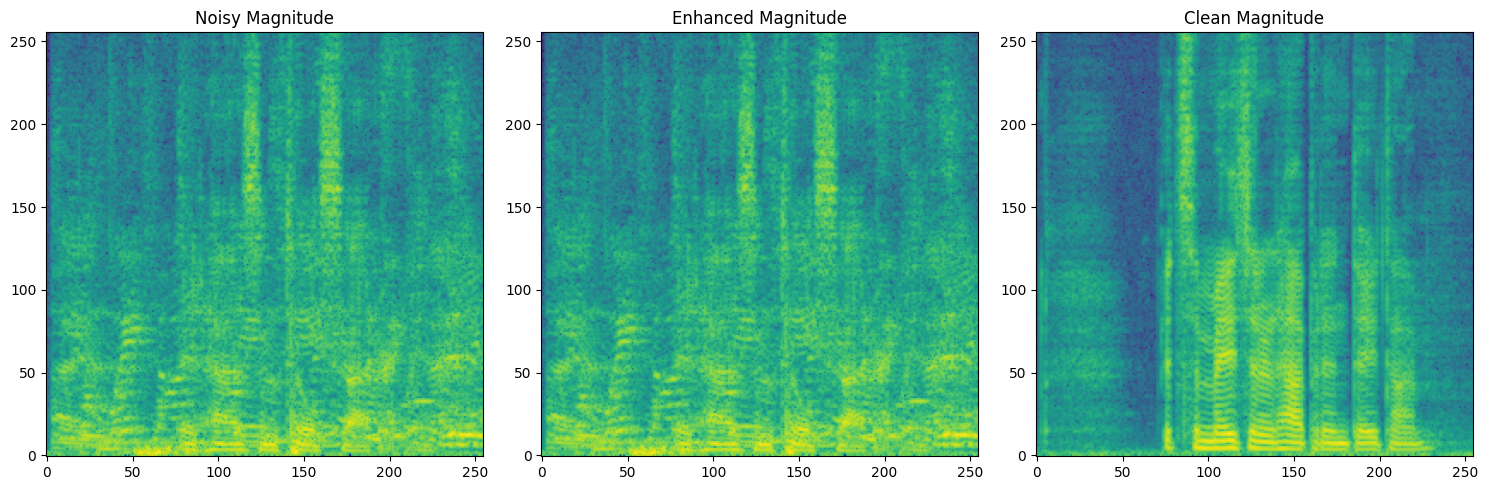

Saving enhanced audio to data/enhanced_audio...


LibsndfileError: Error opening 'data/enhanced_audio/enhanced_0.wav': Format not recognised.

In [5]:
# Step 1: Load the datasets
train_loader = DataLoader(SpeechEnhancementDataset(root_dir='data', dataset_type='training'), batch_size=8, shuffle=True)
test_loader = DataLoader(SpeechEnhancementDataset(root_dir='data', dataset_type='testing'), batch_size=1, shuffle=False)

# Step 2: Initialize the model
model = PhaseReconstructionModel()

# Step 3: Train the model
print("Starting training...")
train_model(model, train_loader, epochs=10, lr=1e-3)
print("Training complete.")

# Step 4: Evaluate the model
print("Evaluating the model on the test set...")
evaluate_model(model, test_loader)

# Step 5: Save enhanced audio
output_dir = 'data/enhanced_audio'
print(f"Saving enhanced audio to {output_dir}...")
save_enhanced_audio(model, test_loader, output_dir=output_dir)
print("Enhanced audio saved successfully.")


In [17]:
# Step 5: Save enhanced audio
output_dir = 'data/enhanced_audio'
print(f"Saving enhanced audio to {output_dir}...")
save_enhanced_audio(model, test_loader, output_dir=output_dir)
print("Enhanced audio saved successfully.")

Saving enhanced audio to data/enhanced_audio...
Enhanced audio shape: (32768,), dtype: float32
Saving enhanced audio to data/enhanced_audio/enhanced_clean_1.wav
Enhanced audio shape: (32768,), dtype: float32
Saving enhanced audio to data/enhanced_audio/enhanced_clean_10.wav
Enhanced audio shape: (32768,), dtype: float32
Saving enhanced audio to data/enhanced_audio/enhanced_clean_100.wav
Enhanced audio shape: (32768,), dtype: float32
Saving enhanced audio to data/enhanced_audio/enhanced_clean_101.wav
Enhanced audio shape: (32768,), dtype: float32
Saving enhanced audio to data/enhanced_audio/enhanced_clean_102.wav
Enhanced audio shape: (32768,), dtype: float32
Saving enhanced audio to data/enhanced_audio/enhanced_clean_103.wav
Enhanced audio shape: (32768,), dtype: float32
Saving enhanced audio to data/enhanced_audio/enhanced_clean_104.wav
Enhanced audio shape: (32768,), dtype: float32
Saving enhanced audio to data/enhanced_audio/enhanced_clean_105.wav
Enhanced audio shape: (32768,), dty

In [20]:
import os
import librosa
import matplotlib.pyplot as plt
from pesq import pesq
from pystoi import stoi

# Constants
SAMPLE_RATE = 16000  # Ensure this matches the sample rate of your audio files

def compute_scores_and_plot(enhanced_dir, clean_dir):
    enhanced_files = sorted([f for f in os.listdir(enhanced_dir) if f.endswith(".wav")])
    clean_files = sorted([f for f in os.listdir(clean_dir) if f.endswith(".wav")])

    pesq_scores = []
    stoi_scores = []

    # Iterate through each pair of enhanced and clean files
    for enhanced_file, clean_file in zip(enhanced_files, clean_files):
        enhanced_path = os.path.join(enhanced_dir, enhanced_file)
        clean_path = os.path.join(clean_dir, clean_file)

        # Load the audio files
        enhanced_audio, _ = librosa.load(enhanced_path, sr=SAMPLE_RATE)
        clean_audio, _ = librosa.load(clean_path, sr=SAMPLE_RATE)

        # Ensure both audio files are the same length
        min_len = min(len(enhanced_audio), len(clean_audio))
        enhanced_audio = enhanced_audio[:min_len]
        clean_audio = clean_audio[:min_len]

        # Compute PESQ score
        pesq_score = pesq(SAMPLE_RATE, clean_audio, enhanced_audio, 'wb')
        pesq_scores.append(pesq_score)

        # Compute STOI score
        stoi_score = stoi(clean_audio, enhanced_audio, SAMPLE_RATE, extended=False)
        stoi_scores.append(stoi_score)

    # Plotting PESQ and STOI Scores
    plt.figure(figsize=(12, 6))
    
    # Plot PESQ scores
    plt.subplot(1, 2, 1)
    plt.plot(pesq_scores, marker='o', linestyle='-', color='b', label='PESQ')
    plt.xlabel('File Index')
    plt.ylabel('PESQ Score')
    plt.title('PESQ Scores per File')
    plt.grid()
    plt.legend()

    # Plot STOI scores
    plt.subplot(1, 2, 2)
    plt.plot(stoi_scores, marker='o', linestyle='-', color='g', label='STOI')
    plt.xlabel('File Index')
    plt.ylabel('STOI Score')
    plt.title('STOI Scores per File')
    plt.grid()
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Print average scores
    avg_pesq = sum(pesq_scores) / len(pesq_scores)
    avg_stoi = sum(stoi_scores) / len(stoi_scores)
    print(f"Average PESQ: {avg_pesq:.2f}")
    print(f"Average STOI: {avg_stoi:.2f}")

    return pesq_scores, stoi_scores, avg_pesq, avg_stoi


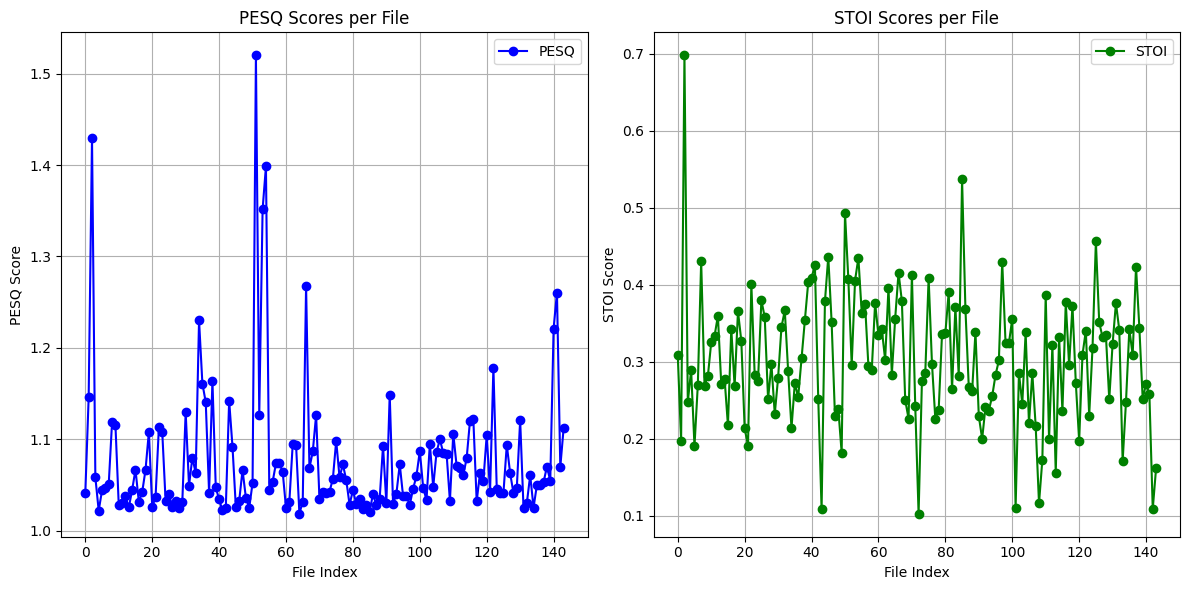

Average PESQ: 1.08
Average STOI: 0.30


In [22]:
# Define directories
enhanced_dir = 'data/enhanced_audio'
clean_dir = 'data/testing/CleanSpeech'

# Compute scores
pesq_scores, stoi_scores, avg_pesq, avg_stoi = compute_scores_and_plot(enhanced_dir, clean_dir)


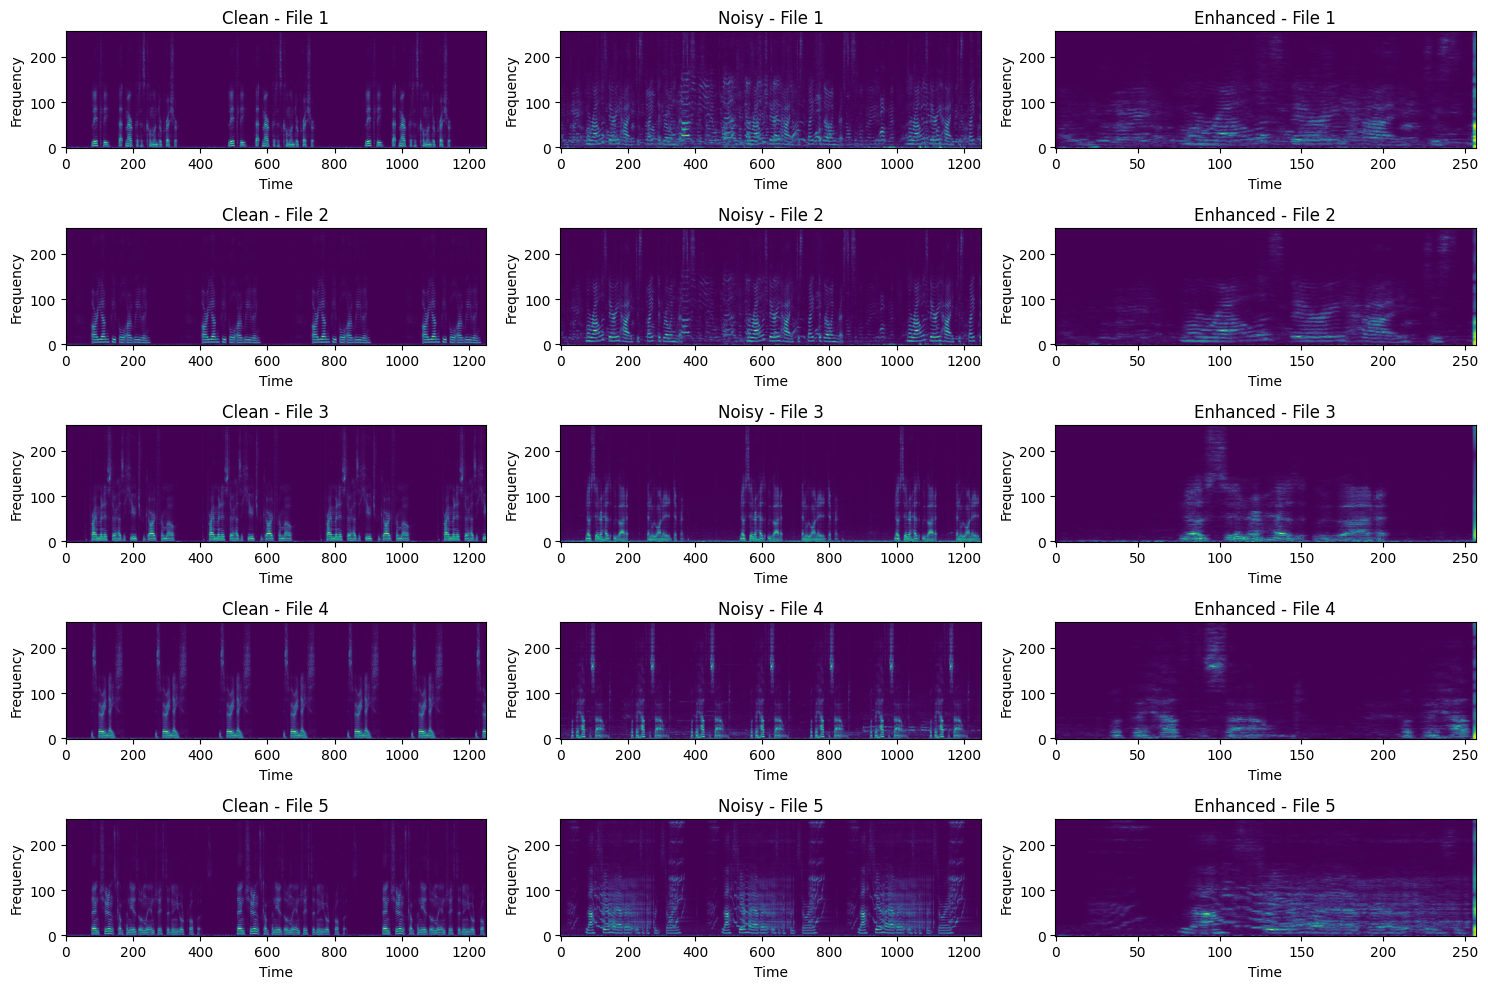

In [23]:
import os
import random
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Constants
SAMPLE_RATE = 16000  # Ensure this matches the sample rate of your audio files

def plot_random_spectrograms(clean_dir, noisy_dir, enhanced_dir, num_files=5):
    # Get list of files in each directory
    clean_files = sorted([f for f in os.listdir(clean_dir) if f.endswith(".wav")])
    noisy_files = sorted([f for f in os.listdir(noisy_dir) if f.endswith(".wav")])
    enhanced_files = sorted([f for f in os.listdir(enhanced_dir) if f.endswith(".wav")])

    # Select random indices for plotting
    indices = random.sample(range(len(clean_files)), num_files)

    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(indices):
        # Load the audio files
        clean_path = os.path.join(clean_dir, clean_files[idx])
        noisy_path = os.path.join(noisy_dir, noisy_files[idx])
        enhanced_path = os.path.join(enhanced_dir, enhanced_files[idx])

        clean_audio, _ = librosa.load(clean_path, sr=SAMPLE_RATE)
        noisy_audio, _ = librosa.load(noisy_path, sr=SAMPLE_RATE)
        enhanced_audio, _ = librosa.load(enhanced_path, sr=SAMPLE_RATE)

        # Compute the spectrograms
        clean_spec = np.abs(librosa.stft(clean_audio, n_fft=512, hop_length=128))
        noisy_spec = np.abs(librosa.stft(noisy_audio, n_fft=512, hop_length=128))
        enhanced_spec = np.abs(librosa.stft(enhanced_audio, n_fft=512, hop_length=128))

        # Plot spectrograms
        plt.subplot(num_files, 3, i * 3 + 1)
        plt.imshow(np.log1p(clean_spec), aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Clean - File {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Frequency")

        plt.subplot(num_files, 3, i * 3 + 2)
        plt.imshow(np.log1p(noisy_spec), aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Noisy - File {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Frequency")

        plt.subplot(num_files, 3, i * 3 + 3)
        plt.imshow(np.log1p(enhanced_spec), aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Enhanced - File {i+1}")
        plt.xlabel("Time")
        plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Example usage
clean_dir = 'data/testing/CleanSpeech'
noisy_dir = 'data/testing/NoisySpeech'
enhanced_dir = 'data/enhanced_audio'

# Plot random spectrograms for comparison
plot_random_spectrograms(clean_dir, noisy_dir, enhanced_dir, num_files=5)
